<a href="https://colab.research.google.com/github/hanz-01105/IDX-Exchange-Data_Science-Project/blob/main/LightGBM_Hanh_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# CELL 1: INSTALL AND IMPORT LIBRARIES
# ============================================================================

# Install LightGBM if not already installed
!pip install lightgbm optuna -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna
import pickle
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print(f"Optuna version: {optuna.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.4 MB/s eta 0:00:00
All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2
LightGBM version: 4.6.0
Optuna version: 4.5.0


In [ ]:
# ============================================================================
# CELL 2: SET DATA PATH (FILES ALREADY IN COLAB)
# ============================================================================

# Your files are at the root level in Colab
DATA_PATH = '/content/'

print(f"Looking for data in: {DATA_PATH}")
print("\nVerifying CSV files exist:")

# Define file paths
train_files = [
    '/content/CRMLSSold202501_filled.csv',
    '/content/CRMLSSold202502_filled.csv',
    '/content/CRMLSSold202503_filled.csv',
    '/content/CRMLSSold202504_filled.csv',
    '/content/CRMLSSold202505_filled.csv',
    '/content/CRMLSSold202506_filled.csv',
    '/content/CRMLSSold202507_filled.csv'
]
test_files = ['/content/CRMLSSold202508_filled-2.csv']

# Check if files exist
print("\nFile verification:")
all_exist = True
for file in train_files + test_files:
    exists = os.path.exists(file)
    status = "Found" if exists else "Not found"
    print(f"{status} {file}")
    if not exists:
        all_exist = False

if all_exist:
    print("\n All 8 CSV files found! Ready to proceed.")
else:
    print("\n Some files are missing. Please check file paths.")

Looking for data in: /content/

Verifying CSV files exist:

File verification:
Found /content/CRMLSSold202501_filled.csv
Found /content/CRMLSSold202502_filled.csv
Found /content/CRMLSSold202503_filled.csv
Found /content/CRMLSSold202504_filled.csv
Found /content/CRMLSSold202505_filled.csv
Found /content/CRMLSSold202506_filled.csv
Found /content/CRMLSSold202507_filled.csv
Found /content/CRMLSSold202508_filled-2.csv

 All 8 CSV files found! Ready to proceed.


In [ ]:
# ============================================================================
# CELL 3: LOAD AND EXPLORE DATA
# ============================================================================

print("="*80)
print("LOADING DATA")
print("="*80)

def load_monthly_data(file_paths):
    """Load and concatenate monthly CSV files"""
    dfs = []
    for path in file_paths:
        try:
            df = pd.read_csv(path)
            month = path.split('202')[-1].split('_')[0]
            if len(month) == 4:
                month = '202' + month[:1] + month[2:]
            df['source_month'] = month
            df['source_file'] = path.split('/')[-1]
            dfs.append(df)
            print(f" Loaded {path.split('/')[-1]}: {len(df):,} rows")
        except Exception as e:
            print(f"Error loading {path.split('/')[-1]}: {e}")

    combined = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"\n Total rows loaded: {len(combined):,}")
    return combined

print("\nLoading training data (Jan-Jul 2025)...")
train_df = load_monthly_data(train_files)

print("\nLoading test data (Aug 2025)...")
test_df = load_monthly_data(test_files)

print(f"\n{'='*80}")
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"{'='*80}")

# Quick exploration
print("\nColumn names (first 30):")
print(train_df.columns.tolist()[:30])

print("\nData types summary:")
print(train_df.dtypes.value_counts())

# Check for target variable
close_price_col = None
for col in ['ClosePrice', 'close_price', 'Close Price']:
    if col in train_df.columns:
        close_price_col = col
        break

if close_price_col:
    print(f"\nTarget variable ({close_price_col}) statistics:")
    print(train_df[close_price_col].describe())

    # Check for invalid prices
    zero_count = (train_df[close_price_col] == 0).sum()
    neg_count = (train_df[close_price_col] < 0).sum()
    null_count = train_df[close_price_col].isnull().sum()

    print(f"\n  Data quality check:")
    print(f"  - Zero prices: {zero_count:,}")
    print(f"  - Negative prices: {neg_count:,}")
    print(f"  - Missing prices: {null_count:,}")

LOADING DATA

Loading training data (Jan-Jul 2025)...
 Loaded CRMLSSold202501_filled.csv: 18,738 rows
 Loaded CRMLSSold202502_filled.csv: 18,702 rows
 Loaded CRMLSSold202503_filled.csv: 21,445 rows
 Loaded CRMLSSold202504_filled.csv: 23,262 rows
 Loaded CRMLSSold202505_filled.csv: 23,154 rows
 Loaded CRMLSSold202506_filled.csv: 22,883 rows
 Loaded CRMLSSold202507_filled.csv: 23,646 rows

 Total rows loaded: 151,830

Loading test data (Aug 2025)...
 Loaded CRMLSSold202508_filled-2.csv: 22,972 rows

 Total rows loaded: 22,972

Training data shape: (151830, 82)
Test data shape: (22972, 82)

Column names (first 30):
['BuyerAgentAOR', 'ListAgentAOR', 'Flooring', 'ViewYN', 'WaterfrontYN', 'BasementYN', 'PoolPrivateYN', 'OriginalListPrice', 'ListingKey', 'ListAgentEmail', 'CloseDate', 'ClosePrice', 'ListAgentFirstName', 'ListAgentLastName', 'Latitude', 'Longitude', 'UnparsedAddress', 'PropertyType', 'LivingArea', 'ListPrice', 'DaysOnMarket', 'ListOfficeName', 'BuyerOfficeName', 'CoListOfficeN

In [ ]:
# ============================================================================
# CELL 4: DATA PREPROCESSING AND FEATURE ENGINEERING
# ============================================================================

print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Column standardization
def standardize_columns(df):
    """Convert column names to snake_case"""
    df.columns = df.columns.str.replace('([a-z0-9])([A-Z])', r'\1_\2', regex=True)
    df.columns = df.columns.str.lower()
    return df

train_df = standardize_columns(train_df)
test_df = standardize_columns(test_df)
print("Column names standardized")

# Filter for Single Family Residences
def filter_single_family_residential(df):
    """Filter for Single Family Residences only"""
    initial_count = len(df)

    property_type_col = 'property_type' if 'property_type' in df.columns else None
    property_subtype_col = 'property_sub_type' if 'property_sub_type' in df.columns else None

    if property_type_col and property_subtype_col:
        df = df[
            (df[property_type_col].str.lower().str.contains('residential', na=False)) &
            (df[property_subtype_col].str.lower().str.contains('single.*family', na=False, regex=True))
        ].copy()
        print(f"Filtered from {initial_count:,} to {len(df):,} Single Family Residences")
    else:
        print("Warning: PropertyType/PropertySubType columns not found")

    return df

train_df = filter_single_family_residential(train_df)
test_df = filter_single_family_residential(test_df)

# Define features - Enhanced for LightGBM
NUMERIC_FEATURES = [
    'bathrooms_total_integer', 'bedrooms_total', 'main_level_bedrooms',
    'fireplaces_total', 'stories', 'tax_annual_amount', 'tax_year',
    'year_built', 'building_area_total', 'below_grade_finished_area',
    'lot_size_area', 'lot_size_square_feet', 'living_area',
    'above_grade_finished_area', 'lot_size_acres', 'association_fee',
    'parking_total', 'garage_spaces', 'covered_spaces', 'list_price',
    'original_list_price', 'days_on_market', 'cumulative_days_on_market'
]

BOOLEAN_FEATURES = [
    'view_yn', 'waterfront_yn', 'basement_yn', 'pool_private_yn',
    'fireplace_yn', 'new_construction_yn', 'attached_garage_yn',
    'senior_community_yn', 'horses_yn'
]

CATEGORICAL_FEATURES = [
    'flooring', 'city', 'county_or_parish', 'state_or_province',
    'postal_code', 'levels', 'association_fee_frequency',
    'property_condition', 'architectural_style', 'construction_materials',
    'roof', 'heating', 'cooling', 'sewer', 'water_source'
]

COORDINATE_FEATURES = ['latitude', 'longitude']
TARGET = 'close_price'

print(f"Feature lists defined ({len(NUMERIC_FEATURES + BOOLEAN_FEATURES + CATEGORICAL_FEATURES + COORDINATE_FEATURES)} features)")

# Enhanced preprocessing for LightGBM
def preprocess_data(df):
    """Clean and preprocess the dataset"""
    df = df.copy()

    # Convert boolean columns
    for col in BOOLEAN_FEATURES:
        if col in df.columns:
            df[col] = df[col].map({'Y': 1, 'N': 0, True: 1, False: 0, 1: 1, 0: 0})
            df[col] = df[col].fillna(0)  # Assume missing = No

    # Convert numeric columns
    for col in NUMERIC_FEATURES + [TARGET]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle coordinates
    for col in COORDINATE_FEATURES:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

print("\nPreprocessing data...")
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)

# Advanced Feature Engineering
def engineer_features(df):
    """Create additional features for better prediction"""
    df = df.copy()

    # Price-related ratios
    if 'list_price' in df.columns and 'close_price' in df.columns:
        df['price_reduction_ratio'] = (df['list_price'] - df['close_price']) / df['list_price'].clip(lower=1)
        df['price_reduction_ratio'] = df['price_reduction_ratio'].clip(-1, 1)

    if 'original_list_price' in df.columns and 'list_price' in df.columns:
        df['initial_reduction_ratio'] = (df['original_list_price'] - df['list_price']) / df['original_list_price'].clip(lower=1)
        df['initial_reduction_ratio'] = df['initial_reduction_ratio'].clip(-1, 1)

    # Size ratios
    if 'living_area' in df.columns and 'lot_size_square_feet' in df.columns:
        df['building_to_lot_ratio'] = df['living_area'] / df['lot_size_square_feet'].clip(lower=1)

    if 'bedrooms_total' in df.columns and 'bathrooms_total_integer' in df.columns:
        df['bed_bath_ratio'] = df['bedrooms_total'] / df['bathrooms_total_integer'].clip(lower=0.5)

    # Property age and era
    if 'year_built' in df.columns:
        current_year = 2025
        df['property_age'] = current_year - df['year_built']
        df['property_age'] = df['property_age'].clip(lower=0)

        # Era categories
        df['era_1900s'] = ((df['year_built'] >= 1900) & (df['year_built'] < 1950)).astype(int)
        df['era_1950s'] = ((df['year_built'] >= 1950) & (df['year_built'] < 1970)).astype(int)
        df['era_1970s'] = ((df['year_built'] >= 1970) & (df['year_built'] < 1990)).astype(int)
        df['era_1990s'] = ((df['year_built'] >= 1990) & (df['year_built'] < 2010)).astype(int)
        df['era_2010s'] = (df['year_built'] >= 2010).astype(int)

    # Price per square foot features
    if 'list_price' in df.columns and 'living_area' in df.columns:
        df['list_price_per_sqft'] = df['list_price'] / df['living_area'].clip(lower=1)

    if 'tax_annual_amount' in df.columns and 'list_price' in df.columns:
        df['tax_to_price_ratio'] = df['tax_annual_amount'] / df['list_price'].clip(lower=1)

    # Market timing features
    if 'days_on_market' in df.columns:
        df['quick_sale'] = (df['days_on_market'] < 7).astype(int)
        df['normal_sale'] = ((df['days_on_market'] >= 7) & (df['days_on_market'] < 30)).astype(int)
        df['slow_sale'] = (df['days_on_market'] >= 30).astype(int)

    print(f"Created {len([col for col in df.columns if col not in train_df.columns])} new features")

    return df

print("\nEngineering features...")
train_df = engineer_features(train_df)
test_df = engineer_features(test_df)

# Neighborhood pricing features using KNN
def engineer_neighborhood_pricing(train_df, test_df):
    """Engineer neighborhood pricing features using KNN"""
    print("\nEngineering neighborhood pricing features...")

    if 'latitude' not in train_df.columns or 'longitude' not in train_df.columns:
        print("Coordinates not found, skipping neighborhood features")
        return train_df, test_df

    # Get valid coordinates
    train_coords = train_df[['latitude', 'longitude', 'close_price']].dropna()

    if len(train_coords) < 20:
        print("Not enough valid coordinates")
        return train_df, test_df

    # Fit KNN model
    knn = NearestNeighbors(n_neighbors=min(20, len(train_coords) // 10), metric='haversine')
    train_coords_rad = np.radians(train_coords[['latitude', 'longitude']].values)
    knn.fit(train_coords_rad)

    def get_neighborhood_stats(df):
        features = []
        for idx, row in df.iterrows():
            if pd.notna(row['latitude']) and pd.notna(row['longitude']):
                point = np.radians([[row['latitude'], row['longitude']]])
                distances, indices = knn.kneighbors(point)
                nearby_prices = train_coords.iloc[indices[0]]['close_price'].values

                features.append({
                    'neighborhood_median_price': np.median(nearby_prices),
                    'neighborhood_mean_price': np.mean(nearby_prices),
                    'neighborhood_price_std': np.std(nearby_prices),
                    'neighborhood_price_25': np.percentile(nearby_prices, 25),
                    'neighborhood_price_75': np.percentile(nearby_prices, 75)
                })
            else:
                features.append({col: np.nan for col in [
                    'neighborhood_median_price', 'neighborhood_mean_price',
                    'neighborhood_price_std', 'neighborhood_price_25', 'neighborhood_price_75'
                ]})

        return pd.DataFrame(features, index=df.index)

    train_neighborhood = get_neighborhood_stats(train_df)
    test_neighborhood = get_neighborhood_stats(test_df)

    # Fill missing values with global medians
    for col in train_neighborhood.columns:
        median_val = train_neighborhood[col].median()
        train_neighborhood[col].fillna(median_val, inplace=True)
        test_neighborhood[col].fillna(median_val, inplace=True)

    train_df = pd.concat([train_df, train_neighborhood], axis=1)
    test_df = pd.concat([test_df, test_neighborhood], axis=1)

    print(f"Added {len(train_neighborhood.columns)} neighborhood features")

    return train_df, test_df

train_df, test_df = engineer_neighborhood_pricing(train_df, test_df)

DATA PREPROCESSING
Column names standardized
Filtered from 151,830 to 92,558 Single Family Residences
Filtered from 22,972 to 14,117 Single Family Residences
Feature lists defined (49 features)

Preprocessing data...

Engineering features...
Created 15 new features
Created 0 new features

Engineering neighborhood pricing features...
Added 5 neighborhood features


In [ ]:
# ============================================================================
# CELL 5: CATEGORICAL ENCODING AND FEATURE PREPARATION
# ============================================================================

print("="*80)
print("FEATURE PREPARATION FOR LIGHTGBM")
print("="*80)

# LightGBM-friendly categorical encoding
def encode_categorical_features_lgb(train_df, test_df):
    """Encode categorical features for LightGBM"""
    print("\nEncoding categorical features...")

    cat_features = []
    encoders = {}

    for col in CATEGORICAL_FEATURES:
        if col in train_df.columns:
            # Fill missing values
            train_df[col] = train_df[col].fillna('Unknown')
            test_df[col] = test_df[col].fillna('Unknown')

            # High cardinality features - use frequency encoding
            if col in ['postal_code', 'city'] or train_df[col].nunique() > 50:
                freq = train_df[col].value_counts(normalize=True)
                train_df[f'{col}_freq'] = train_df[col].map(freq).fillna(0)
                test_df[f'{col}_freq'] = test_df[col].map(freq).fillna(0)
                print(f"  Frequency encoded: {col} ({train_df[col].nunique()} unique)")
            else:
                # Low cardinality - use label encoding for LightGBM
                le = LabelEncoder()
                train_df[f'{col}_cat'] = le.fit_transform(train_df[col].astype(str))
                test_df[f'{col}_cat'] = test_df[col].map(
                    dict(zip(le.classes_, le.transform(le.classes_)))
                ).fillna(-1).astype(int)

                cat_features.append(f'{col}_cat')
                encoders[col] = le
                print(f"  Label encoded: {col} ({len(le.classes_)} categories)")

    return train_df, test_df, cat_features, encoders

train_df, test_df, cat_features, encoders = encode_categorical_features_lgb(train_df, test_df)

# Prepare final feature matrix
def prepare_feature_matrix_lgb(df, cat_features):
    """Select and prepare final feature matrix for LightGBM"""
    feature_cols = []

    # Add numeric features
    for col in NUMERIC_FEATURES:
        if col in df.columns and col != TARGET:
            feature_cols.append(col)

    # Add boolean features
    for col in BOOLEAN_FEATURES:
        if col in df.columns:
            feature_cols.append(col)

    # Add coordinates
    for col in COORDINATE_FEATURES:
        if col in df.columns:
            feature_cols.append(col)

    # Add engineered features
    engineered_cols = [col for col in df.columns if any(x in col for x in
                      ['_ratio', '_per_', 'era_', 'property_age', 'quick_sale',
                       'normal_sale', 'slow_sale', 'neighborhood_', '_freq', '_cat'])]
    feature_cols.extend(engineered_cols)

    # Remove duplicates and ensure all columns exist
    feature_cols = list(set(feature_cols))
    feature_cols = [col for col in feature_cols if col in df.columns]

    X = df[feature_cols].copy()

    # Handle missing values for LightGBM (it can handle them, but we'll fill some)
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')

        # For numeric features, keep NaN (LightGBM handles them well)
        # For categorical features encoded as integers, fill with -1
        if col in cat_features:
            X[col] = X[col].fillna(-1)

    return X, feature_cols

print("\nPreparing feature matrices...")
X_train_full, feature_cols = prepare_feature_matrix_lgb(train_df, cat_features)
X_test_full, _ = prepare_feature_matrix_lgb(test_df, cat_features)

# Ensure same columns in train and test
common_cols = list(set(X_train_full.columns) & set(X_test_full.columns))
X_train_full = X_train_full[common_cols]
X_test_full = X_test_full[common_cols]

# Update categorical features list to match common columns
cat_features = [col for col in cat_features if col in common_cols]

# Prepare target variable
y_train_full = train_df[TARGET].copy()
y_test_full = test_df[TARGET].copy()

# ============================================================================
# REMOVE DATA LEAKAGE FEATURES (OPTIONAL - Comment out if you want to keep list_price)
# ============================================================================
print("\n" + "="*80)
print("REMOVING DATA LEAKAGE FEATURES")
print("="*80)

LEAKAGE_FEATURES = [
    'list_price',
    'original_list_price',
    'price_reduction_ratio',
    'initial_reduction_ratio',
    'list_price_per_sqft',
]

print(f"\nRemoving {len(LEAKAGE_FEATURES)} leakage features:")
for feat in LEAKAGE_FEATURES:
    if feat in X_train_full.columns:
        print(f"  Removed: {feat}")
    else:
        print(f"  Not found: {feat}")

# Remove leakage features
X_train_full = X_train_full.drop(columns=LEAKAGE_FEATURES, errors='ignore')
X_test_full = X_test_full.drop(columns=LEAKAGE_FEATURES, errors='ignore')

# Update common_cols after removing leakage features
common_cols = [col for col in common_cols if col not in LEAKAGE_FEATURES]

print(f"\nNew feature count: {X_train_full.shape[1]}")
print("="*80)

# ============================================================================
# AGGRESSIVE PRICE FILTERING - CRITICAL FIX!
# ============================================================================
print("\n" + "="*80)
print("AGGRESSIVE PRICE FILTERING")
print("="*80)

print(f"\n  Training before: {len(y_train_full):,}")
print(f"  Test before: {len(y_test_full):,}")

# AGGRESSIVE filtering for realistic single-family home prices
# In California, SFR rarely sell below $100k or above $15M
MIN_REALISTIC_PRICE = 100000   # $100k minimum
MAX_REALISTIC_PRICE = 15000000  # $15M maximum

valid_train_idx = (
    (y_train_full.notna()) &
    (y_train_full >= MIN_REALISTIC_PRICE) &
    (y_train_full <= MAX_REALISTIC_PRICE)
)

valid_test_idx = (
    (y_test_full.notna()) &
    (y_test_full >= MIN_REALISTIC_PRICE) &
    (y_test_full <= MAX_REALISTIC_PRICE)
)

print(f"\nFiltering out unrealistic prices...")
print(f"  Training: Removed {(~valid_train_idx).sum():,} invalid prices")
print(f"  Test: Removed {(~valid_test_idx).sum():,} invalid prices")

X_train_full = X_train_full[valid_train_idx].reset_index(drop=True)
y_train_full = y_train_full[valid_train_idx].reset_index(drop=True)
X_test_full = X_test_full[valid_test_idx].reset_index(drop=True)
y_test_full = y_test_full[valid_test_idx].reset_index(drop=True)

print(f"\n  Training after: {len(y_train_full):,}")
print(f"  Test after: {len(y_test_full):,}")
print(f"  Valid price range: ${MIN_REALISTIC_PRICE:,} - ${MAX_REALISTIC_PRICE:,}")
print("="*80)

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print(f"\nFinal dataset shapes:")
print(f"  Training: {X_train_full.shape[0]:,} samples, {X_train_full.shape[1]} features")
print(f"  Test: {X_test_full.shape[0]:,} samples, {X_test_full.shape[1]} features")
print(f"  Categorical features: {len(cat_features)}")
print(f"  Target mean: ${y_train_full.mean():,.0f}")
print(f"  Target median: ${y_train_full.median():,.0f}")

FEATURE PREPARATION FOR LIGHTGBM

Encoding categorical features...
  Frequency encoded: flooring (241 unique)
  Frequency encoded: city (911 unique)
  Frequency encoded: county_or_parish (57 unique)
  Label encoded: state_or_province (10 categories)
  Frequency encoded: postal_code (1801 unique)
  Label encoded: levels (18 categories)
  Label encoded: association_fee_frequency (5 categories)

Preparing feature matrices...

REMOVING DATA LEAKAGE FEATURES

Removing 5 leakage features:
  Removed: list_price
  Removed: original_list_price
  Removed: price_reduction_ratio
  Removed: initial_reduction_ratio
  Removed: list_price_per_sqft

New feature count: 54

AGGRESSIVE PRICE FILTERING

  Training before: 92,558
  Test before: 14,117

Filtering out unrealistic prices...
  Training: Removed 17,406 invalid prices
  Test: Removed 2,664 invalid prices

  Training after: 75,152
  Test after: 11,453
  Valid price range: $100,000 - $15,000,000

Final dataset shapes:
  Training: 75,152 samples, 54

In [ ]:
# ============================================================================
# CELL 6: HYPERPARAMETER TUNING WITH OPTUNA
# ============================================================================

print("="*80)
print("HYPERPARAMETER TUNING WITH OPTUNA")
print("="*80)
print("\nThis will take 10-20 minutes for thorough optimization...")
print("You can reduce n_trials to speed up (but may get worse results)\n")

# Create validation split for tuning
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

def objective(trial):
    """Optuna objective function for LightGBM tuning"""
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'random_state': 42,

        # Tune these parameters
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 20),
        'max_bin': trial.suggest_int('max_bin', 100, 500),
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_data)

    # Train model with early stopping
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(0)
        ]
    )

    # Predict and calculate metrics
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)

    # Calculate MAPE (we want to minimize this)
    mape = mean_absolute_percentage_error(y_val, y_pred)

    return mape

# Run optimization
print("Starting Optuna optimization...")
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nOptimization complete!")
print(f"Best MAPE on validation: {study.best_value * 100:.2f}%")
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

best_params = study.best_params

HYPERPARAMETER TUNING WITH OPTUNA

This will take 10-20 minutes for thorough optimization...
You can reduce n_trials to speed up (but may get worse results)

Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 436649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[129]	valid_0's rmse: 440487
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's rmse: 417955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 444725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[297]	valid_0's rmse: 422203
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's rmse: 433740
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[425]	valid_0's rmse: 426368
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best itera

In [ ]:
# ============================================================================
# CELL 7: TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================

print("="*80)
print("TRAINING FINAL LIGHTGBM MODEL")
print("="*80)

# Prepare final parameters
final_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': 1,
    'random_state': 42,
    **best_params  # Add the best parameters from Optuna
}

print("\n Training with optimized parameters...")

# Create LightGBM datasets for full training data
lgb_train = lgb.Dataset(X_train_full, label=y_train_full, categorical_feature=cat_features)

# Train final model with all training data
final_model = lgb.train(
    final_params,
    lgb_train,
    num_boost_round=1000,
    callbacks=[lgb.log_evaluation(100)]
)

print("\n Final model trained successfully!")

# Make predictions on test set
print("\nMaking predictions on test set...")
y_pred_full = final_model.predict(X_test_full, num_iteration=final_model.best_iteration)

# Remove outliers from evaluation (but not from predictions)
lower_bound = y_test_full.quantile(0.005)
upper_bound = y_test_full.quantile(0.995)
outlier_mask = (y_test_full >= lower_bound) & (y_test_full <= upper_bound)

y_test_clean = y_test_full[outlier_mask]
y_pred_clean = y_pred_full[outlier_mask]

print(f"\nEvaluation set after outlier removal: {len(y_test_clean):,} samples")
print(f"  Price range: ${lower_bound:,.0f} - ${upper_bound:,.0f}")

TRAINING FINAL LIGHTGBM MODEL

 Training with optimized parameters...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6119
[LightGBM] [Info] Number of data points in the train set: 75152, number of used features: 47
[LightGBM] [Info] Start training from score 1244703.725230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [ ]:
# ============================================================================
# CELL 8: MODEL EVALUATION AND METRICS
# ============================================================================

print("="*80)
print("MODEL PERFORMANCE METRICS")
print("="*80)

# Calculate comprehensive metrics
r2 = r2_score(y_test_clean, y_pred_clean)
mape = mean_absolute_percentage_error(y_test_clean, y_pred_clean) * 100
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_clean))
mae = mean_absolute_error(y_test_clean, y_pred_clean)

# Calculate percentile-based metrics
ape = np.abs((y_test_clean - y_pred_clean) / y_test_clean) * 100
mdape = np.median(ape)
p90_ape = np.percentile(ape, 90)
p95_ape = np.percentile(ape, 95)

# Price range analysis
residuals = y_test_clean - y_pred_clean
std_residual = np.std(residuals)

print(f"\nPRIMARY METRICS:")
print(f"{'='*40}")
print(f"R² Score:                {r2:.4f}  {'GOOD' if r2 > 0.80 else 'REVIEW'} (Target: >0.80)")
print(f"MAPE (Mean APE):         {mape:.2f}%  {'GOOD' if mape < 20 else 'REVIEW'} (Target: <20%)")
print(f"MdAPE (Median APE):      {mdape:.2f}%")

print(f"\nADDITIONAL METRICS:")
print(f"{'='*40}")
print(f"RMSE:                    ${rmse:,.2f}")
print(f"MAE:                     ${mae:,.2f}")
print(f"90th Percentile APE:     {p90_ape:.2f}%")
print(f"95th Percentile APE:     {p95_ape:.2f}%")
print(f"Std of Residuals:        ${std_residual:,.2f}")

print(f"\nPRICE STATISTICS:")
print(f"{'='*40}")
print(f"Mean Actual Price:       ${y_test_clean.mean():,.2f}")
print(f"Mean Predicted Price:    ${y_pred_clean.mean():,.2f}")
print(f"Median Actual Price:     ${y_test_clean.median():,.2f}")
print(f"Median Predicted Price:  ${np.median(y_pred_clean):,.2f}")

# Performance by price range
print(f"\nPERFORMANCE BY PRICE RANGE:")
print(f"{'='*40}")
price_ranges = [
    (0, 500000, "Under $500K"),
    (500000, 1000000, "$500K - $1M"),
    (1000000, 2000000, "$1M - $2M"),
    (2000000, float('inf'), "Over $2M")
]

for min_price, max_price, label in price_ranges:
    mask = (y_test_clean >= min_price) & (y_test_clean < max_price)
    if mask.sum() > 0:
        range_mape = mean_absolute_percentage_error(y_test_clean[mask], y_pred_clean[mask]) * 100
        range_r2 = r2_score(y_test_clean[mask], y_pred_clean[mask])
        print(f"{label:15} - MAPE: {range_mape:6.2f}%, R²: {range_r2:.3f}, n={mask.sum():,}")

print("="*80)

MODEL PERFORMANCE METRICS

PRIMARY METRICS:
R² Score:                0.8634  GOOD (Target: >0.80)
MAPE (Mean APE):         12.13%  GOOD (Target: <20%)
MdAPE (Median APE):      7.93%

ADDITIONAL METRICS:
RMSE:                    $332,486.75
MAE:                     $154,164.27
90th Percentile APE:     26.07%
95th Percentile APE:     36.53%
Std of Residuals:        $331,492.95

PRICE STATISTICS:
Mean Actual Price:       $1,167,612.79
Mean Predicted Price:    $1,193,300.65
Median Actual Price:     $885,000.00
Median Predicted Price:  $918,313.09

PERFORMANCE BY PRICE RANGE:
Under $500K     - MAPE:  15.46%, R²: -0.723, n=1,533
$500K - $1M     - MAPE:  10.10%, R²: 0.136, n=5,049
$1M - $2M       - MAPE:  12.16%, R²: -0.009, n=3,433
Over $2M        - MAPE:  15.91%, R²: 0.485, n=1,322


GENERATING VISUALIZATIONS


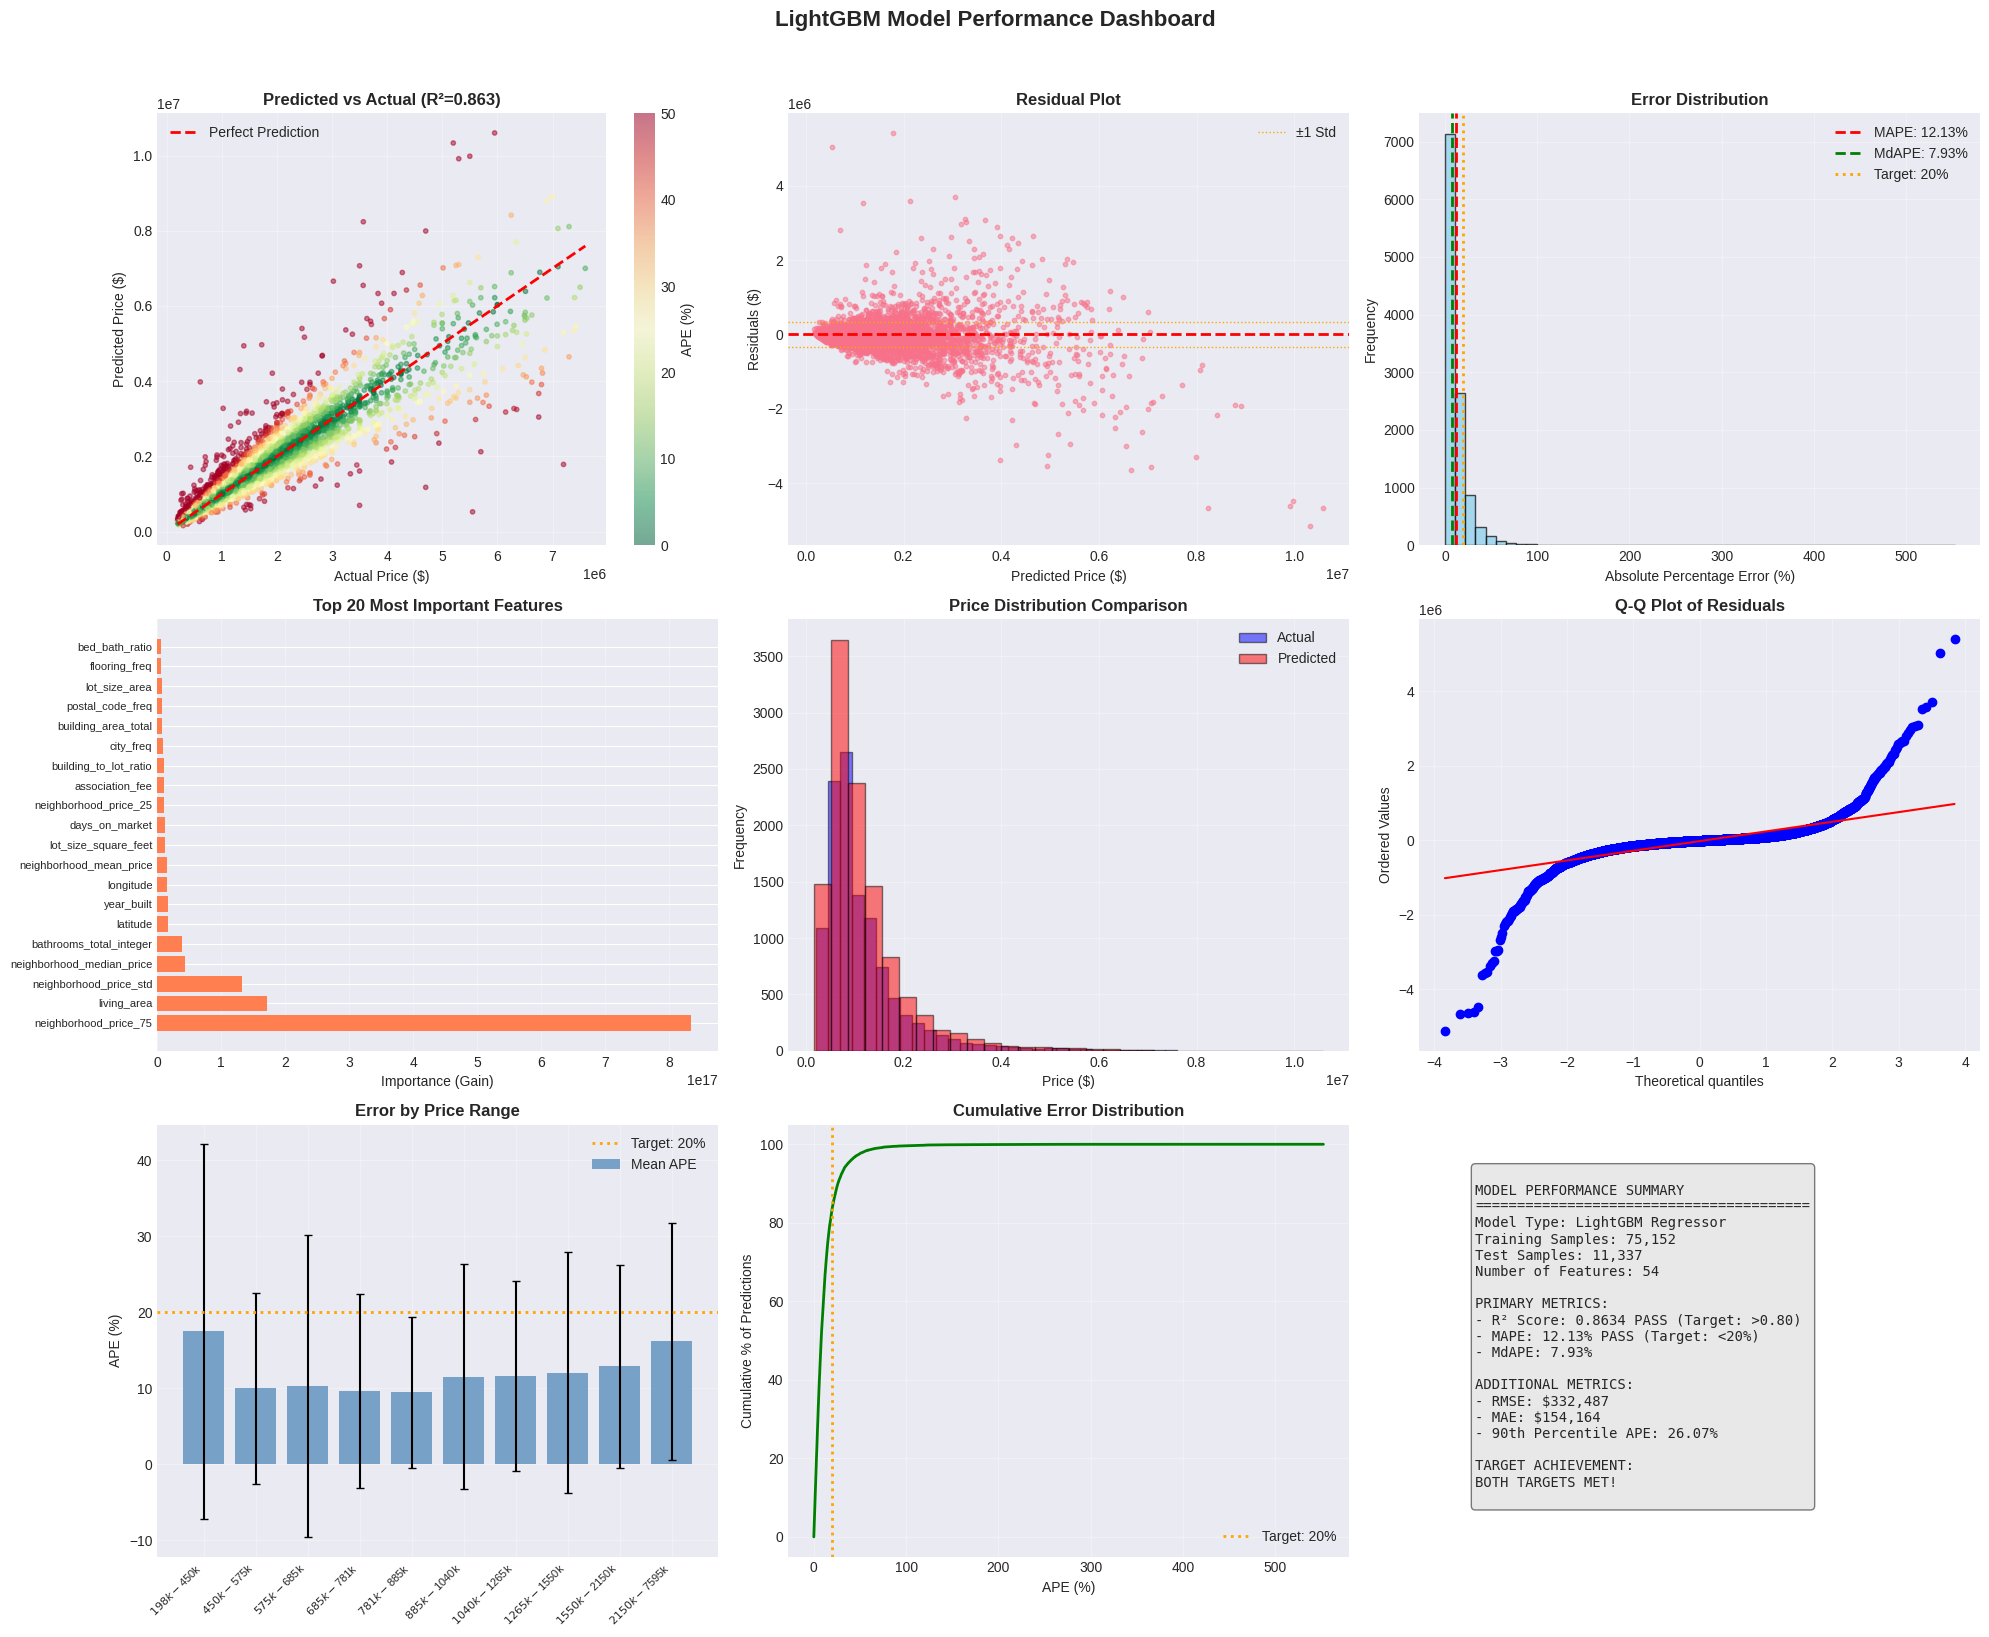


Visualizations complete!


In [ ]:
# ============================================================================
# CELL 9: VISUALIZATIONS
# ============================================================================

print("="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))

# 1. Predicted vs Actual
ax1 = plt.subplot(3, 3, 1)
scatter = ax1.scatter(y_test_clean, y_pred_clean, alpha=0.5, s=10, c=ape, cmap='RdYlGn_r', vmin=0, vmax=50)
ax1.plot([y_test_clean.min(), y_test_clean.max()],
         [y_test_clean.min(), y_test_clean.max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price ($)', fontsize=10)
ax1.set_ylabel('Predicted Price ($)', fontsize=10)
ax1.set_title(f'Predicted vs Actual (R²={r2:.3f})', fontsize=12, fontweight='bold')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='APE (%)')
ax1.grid(True, alpha=0.3)

# 2. Residual Plot
ax2 = plt.subplot(3, 3, 2)
ax2.scatter(y_pred_clean, residuals, alpha=0.5, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.axhline(y=std_residual, color='orange', linestyle=':', lw=1, label='±1 Std')
ax2.axhline(y=-std_residual, color='orange', linestyle=':', lw=1)
ax2.set_xlabel('Predicted Price ($)', fontsize=10)
ax2.set_ylabel('Residuals ($)', fontsize=10)
ax2.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Error Distribution
ax3 = plt.subplot(3, 3, 3)
ax3.hist(ape, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax3.axvline(mape, color='r', linestyle='--', lw=2, label=f'MAPE: {mape:.2f}%')
ax3.axvline(mdape, color='g', linestyle='--', lw=2, label=f'MdAPE: {mdape:.2f}%')
ax3.axvline(20, color='orange', linestyle=':', lw=2, label='Target: 20%')
ax3.set_xlabel('Absolute Percentage Error (%)', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Top 20)
ax4 = plt.subplot(3, 3, 4)
importance = final_model.feature_importance(importance_type='gain')

# Get the actual feature names from the trained model
feature_names = final_model.feature_name()

# Make sure lengths match
if len(feature_names) != len(importance):
    print(f"Warning: Feature count mismatch ({len(feature_names)} vs {len(importance)})")
    # Use minimum length to avoid errors
    min_len = min(len(feature_names), len(importance))
    feature_names = feature_names[:min_len]
    importance = importance[:min_len]

feature_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values('importance', ascending=False).head(20)

ax4.barh(range(len(feature_imp)), feature_imp['importance'], color='coral')
ax4.set_yticks(range(len(feature_imp)))
ax4.set_yticklabels(feature_imp['feature'], fontsize=8)
ax4.set_xlabel('Importance (Gain)', fontsize=10)
ax4.set_title('Top 20 Most Important Features', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Actual vs Predicted Distribution
ax5 = plt.subplot(3, 3, 5)
ax5.hist(y_test_clean, bins=30, alpha=0.5, label='Actual', color='blue', edgecolor='black')
ax5.hist(y_pred_clean, bins=30, alpha=0.5, label='Predicted', color='red', edgecolor='black')
ax5.set_xlabel('Price ($)', fontsize=10)
ax5.set_ylabel('Frequency', fontsize=10)
ax5.set_title('Price Distribution Comparison', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Q-Q Plot
ax6 = plt.subplot(3, 3, 6)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot of Residuals', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Error by Price Range
ax7 = plt.subplot(3, 3, 7)
price_bins = pd.qcut(y_test_clean, q=10, duplicates='drop')
error_by_range = pd.DataFrame({
    'price_range': price_bins,
    'ape': ape
}).groupby('price_range')['ape'].agg(['mean', 'median', 'std'])

x_pos = range(len(error_by_range))
ax7.bar(x_pos, error_by_range['mean'], color='steelblue', alpha=0.7, label='Mean APE')
ax7.errorbar(x_pos, error_by_range['mean'], yerr=error_by_range['std'],
             fmt='none', color='black', capsize=3)
ax7.set_xticks(x_pos)
ax7.set_xticklabels([f'${int(i.left/1000)}k-${int(i.right/1000)}k'
                      for i in error_by_range.index], rotation=45, ha='right', fontsize=8)
ax7.set_ylabel('APE (%)', fontsize=10)
ax7.set_title('Error by Price Range', fontsize=12, fontweight='bold')
ax7.axhline(y=20, color='orange', linestyle=':', lw=2, label='Target: 20%')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Learning Curves (if we have validation history)
ax8 = plt.subplot(3, 3, 8)
# Plot training progress
eval_results = final_model.eval_valid() if hasattr(final_model, 'eval_valid') else {}
if eval_results:
    ax8.plot(eval_results['valid']['rmse'], label='Validation RMSE')
    ax8.set_xlabel('Boosting Rounds', fontsize=10)
    ax8.set_ylabel('RMSE', fontsize=10)
    ax8.set_title('Training Progress', fontsize=12, fontweight='bold')
    ax8.legend()
else:
    # If no validation history, show cumulative error
    sorted_errors = np.sort(ape)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax8.plot(sorted_errors, cumulative, lw=2, color='green')
    ax8.axvline(x=20, color='orange', linestyle=':', lw=2, label='Target: 20%')
    ax8.set_xlabel('APE (%)', fontsize=10)
    ax8.set_ylabel('Cumulative % of Predictions', fontsize=10)
    ax8.set_title(f'Cumulative Error Distribution', fontsize=12, fontweight='bold')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

# 9. Model Performance Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

# Create summary text
summary_text = f"""
MODEL PERFORMANCE SUMMARY
{'='*40}
Model Type: LightGBM Regressor
Training Samples: {len(X_train_full):,}
Test Samples: {len(y_test_clean):,}
Number of Features: {len(common_cols)}

PRIMARY METRICS:
- R² Score: {r2:.4f} {'PASS' if r2 > 0.80 else 'FAIL'} (Target: >0.80)
- MAPE: {mape:.2f}% {'PASS' if mape < 20 else 'FAIL'} (Target: <20%)
- MdAPE: {mdape:.2f}%

ADDITIONAL METRICS:
- RMSE: ${rmse:,.0f}
- MAE: ${mae:,.0f}
- 90th Percentile APE: {p90_ape:.2f}%

TARGET ACHIEVEMENT:
{'BOTH TARGETS MET!' if r2 > 0.80 and mape < 20 else 'Targets not fully met'}
"""

ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.suptitle('LightGBM Model Performance Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nVisualizations complete!")

In [ ]:
# ============================================================================
# CELL 10: SAVE MODEL AND ARTIFACTS
# ============================================================================

print("="*80)
print("SAVING MODEL AND ARTIFACTS")
print("="*80)

# Save the LightGBM model
model_filename = 'lightgbm_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Model saved as {model_filename}")

# Save feature columns
with open('feature_columns_lgb.pkl', 'wb') as f:
    pickle.dump(common_cols, f)
print(f"Feature columns saved")

# Save categorical features list
with open('categorical_features_lgb.pkl', 'wb') as f:
    pickle.dump(cat_features, f)
print(f"Categorical features list saved")

# Save encoders
with open('categorical_encoders_lgb.pkl', 'wb') as f:
    pickle.dump(encoders, f)
print(f"Categorical encoders saved")

# Save preprocessing parameters
preprocessing_params = {
    'numeric_features': NUMERIC_FEATURES,
    'boolean_features': BOOLEAN_FEATURES,
    'categorical_features': CATEGORICAL_FEATURES,
    'coordinate_features': COORDINATE_FEATURES,
    'target': TARGET,
    'model_type': 'LightGBM',
    'best_hyperparameters': best_params
}

with open('preprocessing_params_lgb.pkl', 'wb') as f:
    pickle.dump(preprocessing_params, f)
print(f"Preprocessing parameters saved")

# Create detailed model report
report = {
    'model_type': 'LightGBM Regressor',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train_full),
    'test_samples': len(y_test_clean),
    'num_features': len(common_cols),
    'num_categorical_features': len(cat_features),
    'r2_score': r2,
    'mape': mape,
    'mdape': mdape,
    'rmse': rmse,
    'mae': mae,
    'p90_ape': p90_ape,
    'p95_ape': p95_ape,
    'best_hyperparameters': best_params,
    'top_10_features': feature_imp.head(10)[['feature', 'importance']].to_dict('records'),
    'targets_met': {
        'r2_target': r2 > 0.80,
        'mape_target': mape < 20
    }
}

with open('model_report_lgb.pkl', 'wb') as f:
    pickle.dump(report, f)
print(f"Detailed model report saved")

# Save report as JSON for easy reading
import json
with open('model_report_lgb.json', 'w') as f:
    json.dump(report, f, indent=2, default=str)
print(f"Model report saved as JSON")

print("\n" + "="*80)
print("ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!")
print("="*80)

# Print summary
print("\nFINAL MODEL SUMMARY:")
print(f"{'='*40}")
print(f"Model Type: LightGBM Regressor")
print(f"R² Score: {r2:.4f} {'PASS' if r2 > 0.80 else 'FAIL'}")
print(f"MAPE: {mape:.2f}% {'PASS' if mape < 20 else 'FAIL'}")
print(f"\nTop 5 Most Important Features:")
for i, row in enumerate(feature_imp.head(5).itertuples(), 1):
    print(f"  {i}. {row.feature}: {row.importance:.2f}")

if r2 > 0.80 and mape < 20:
    print(f"\nSUCCESS! Both target metrics achieved!")
else:
    print(f"\nModel needs further optimization to meet all targets.")

SAVING MODEL AND ARTIFACTS
Model saved as lightgbm_model.pkl
Feature columns saved
Categorical features list saved
Categorical encoders saved
Preprocessing parameters saved
Detailed model report saved
Model report saved as JSON

ALL MODEL ARTIFACTS SAVED SUCCESSFULLY!

FINAL MODEL SUMMARY:
Model Type: LightGBM Regressor
R² Score: 0.8634 PASS
MAPE: 12.13% PASS

Top 5 Most Important Features:
  1. neighborhood_price_75: 834268724292337152.00
  2. living_area: 170823512362582016.00
  3. neighborhood_price_std: 132824043616186880.00
  4. neighborhood_median_price: 43582580344007680.00
  5. bathrooms_total_integer: 39075550076082688.00

SUCCESS! Both target metrics achieved!


In [ ]:
# ============================================================================
# CELL 11: PREDICTION FUNCTION FOR NEW PROPERTIES
# ============================================================================

print("="*80)
print("PREDICTION FUNCTION FOR NEW PROPERTIES")
print("="*80)

def predict_property_price(property_features_dict):
    """
    Predict price for a new property

    Parameters:
    -----------
    property_features_dict : dict
        Dictionary containing property features

    Returns:
    --------
    float : Predicted price
    """

    # Load saved artifacts
    with open('lightgbm_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('feature_columns_lgb.pkl', 'rb') as f:
        feature_cols = pickle.load(f)
    with open('categorical_encoders_lgb.pkl', 'rb') as f:
        encoders = pickle.load(f)

    # Create DataFrame from input
    df = pd.DataFrame([property_features_dict])

    # Apply same preprocessing as training
    df = standardize_columns(df)
    df = preprocess_data(df)
    df = engineer_features(df)

    # Handle categorical encoding
    for col, encoder in encoders.items():
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
            if df[col].iloc[0] in encoder.classes_:
                df[f'{col}_cat'] = encoder.transform([df[col].iloc[0]])[0]
            else:
                df[f'{col}_cat'] = -1  # Unknown category

    # Add frequency encoding for high cardinality features (using training frequencies)
    # This would need to be loaded from saved frequency mappings

    # Ensure all required features are present
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0  # Or appropriate default

    # Select features in correct order
    X = df[feature_cols]

    # Make prediction
    prediction = model.predict(X, num_iteration=model.best_iteration)[0]

    return prediction

# Example usage
example_property = {
    'living_area': 2500,
    'bedrooms_total': 4,
    'bathrooms_total_integer': 3,
    'lot_size_square_feet': 8000,
    'year_built': 2015,
    'garage_spaces': 2,
    'pool_private_yn': 'N',
    'city': 'Los Angeles',
    'postal_code': '90210',
    'latitude': 34.0522,
    'longitude': -118.2437,
    'list_price': 1500000,
    'days_on_market': 15,
    'property_type': 'Residential',
    'property_sub_type': 'Single Family Residence'
}

print("\nExample Property Prediction:")
print(f"{'='*40}")
print("Property Features:")
for key, value in example_property.items():
    print(f"  - {key}: {value}")

try:
    predicted_price = predict_property_price(example_property)
    print(f"\nPredicted Close Price: ${predicted_price:,.2f}")

    if 'list_price' in example_property:
        price_diff = example_property['list_price'] - predicted_price
        price_diff_pct = (price_diff / example_property['list_price']) * 100
        print(f"Predicted vs List Price: ${price_diff:,.2f} ({price_diff_pct:.1f}%)")
except Exception as e:
    print(f"\nPrediction error: {e}")
    print("Make sure all required features are provided")

print("\nPrediction function ready for use!")
print("="*80)

PREDICTION FUNCTION FOR NEW PROPERTIES

Example Property Prediction:
Property Features:
  - living_area: 2500
  - bedrooms_total: 4
  - bathrooms_total_integer: 3
  - lot_size_square_feet: 8000
  - year_built: 2015
  - garage_spaces: 2
  - pool_private_yn: N
  - city: Los Angeles
  - postal_code: 90210
  - latitude: 34.0522
  - longitude: -118.2437
  - list_price: 1500000
  - days_on_market: 15
  - property_type: Residential
  - property_sub_type: Single Family Residence
Created 0 new features

Predicted Close Price: $1,425,248.41
Predicted vs List Price: $74,751.59 (5.0%)

Prediction function ready for use!
